# Lab Three: Clustering


*Contributors*: Balaji Avvaru, Joshua Eysenbach, Vijay Kaniti, Daniel Turner

## Business Understanding 1

As outlined in *Lab One: Visualization and Data Preprocessing*, this analysis uses a dataset built for categorizing patients as with or without a cardiovascular disease (CVD) diagnosis.  It originally contained a collection of 11 attributes that were gathered with the intention of trying to identify potential characteristics of individuals that correlate with heart disease. Both in *Lab One* and the *Minilab*, we made some adjustments to the original dataset that included cleaning up bad data, adding new variables like *BMI*, and changing the structure of some attributes like *cholesterol* and *glucose* to be one-hot encoded into multiple columns.

Our goal of the models will be to cluster the associated cardiovascular disease (CVD) diagnosis to create a new feature that we will use to try and improve our classification from lab-2.

To measure the effectiveness of each clustering algorithm we will be comparing the calculated Silhouette score (i.e. Silhouette Coefficient).

**Silhouette Score** – “The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values indicate that the values located in each cluster have little in common with one another, suggesting the cluster was not based on a unified characteristic. We are going to use Silhouette score because it's a simple scoring metric to interpret, it shows a direct correlation to additional metrics we've reviewed such as homogeneity, completeness and V-measure.

For each clustering algorithm, we will take the clustering output and use as a new feature to our random forest classification to see if it improves our classification accuracy.

## Data Understanding 1

The features included are described on the Kaggle page<sup>(0-1) </sup> for this data as being separable into three categories:
* *Objective*: Factual initial information about the patient;
* *Examination*: Information resulting from medical examination;
* *Subjective*: Information given by the patient.

Distinctions between the different attributes are paramount to interpreting and qualifying results of analysis and modeling of this data as they can represent varying degrees of validity and potential biases, so it is important that we keep this in mind as we explore the data and eventually make any recommendations. For example, we would likely assume blood pressure measurements will be reasonably accurate as they were taken by a trained health professional, but should be wary of a patient's proclivity to be honest when asked whether they are a regular smoker or drinker.

#### Data Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import *
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

df_onehot = pd.read_csv("https://raw.githubusercontent.com/jteysen/MSDS-7331-Machine-Learning-I/master/Code/Lab3/CVD_3.csv")

<b>Summary of Data Preprocessing (Done in *Lab-1* and *mini-lab*)</b>

 - Since the ID field is simply the ordered numbering of all of the observations, it is not useful to us so we droped it from our data frame.
 
 
 - We also see that the scale of age in days is cumbersome, so we converted it to years. The age range of 29 to 65 with a mean of 53 years is a fairly narrow scope, so we don;t have high hope for this variable to contribute much to any clustering.
 
 
 - The records are checked to see if any are exact duplicates. There are 24 individuals with the same values for this relatively small list of attributes is entirely possible in a dataset of 70,000. All of the duplicates appear very near the average or medians for the different attributes, making the likelihood of the duplicates high and their legitimacy believable. For that reason, we kept them in the dataset.
 
 
 - For age, we see that the lone 29 year old subject is a statistical outlier but not an unreasonable possibilty, so we kept the data point.
 
 
 - We knew it is impossible to have a diastolic blood pressure that is higher than a systolic blood pressure, and because the minimums and maximums of ap_hi and ap_lo overlap. There are 64 observations where ap_lo is greater than ap_hi. Viewing the records where ap_lo > ap_hi, it appears we could assume that all of these were accidentally entered in reverse, and simply swap the values rather than delete these observations due to the mistakes.
 
 
 - For the height attribute, we assumed the 250 cm giant is an anomaly and removed that observation from the data frame. The unreasonably short records could be from entry errors stemming from accidental unit confusion (we know these aren't just children because the min age is 29). For example, the minimum of 55 cm could have been an erroneous entry for 5ft 5 inches, but it would be near impossible for us discern when this is truly the case for every observation. We used the cutoff of 120 cm (approx 4 ft) for the lower end of heights. 
 
 
 - The same goes for the weights; the very low values are not realistic, but the max of 200 kg is still within the realm of possibility. We used 40 kg as a cutoff. These cutoffs are somewhat arbitrary, but designed with the desire to minimize both the the number of extreme values and number of records removed.
 
 
 - We created new feature BMI(Body mass index) which is a ratio of weight (in kilograms) and height (in meters squared). A BMI over 25 is considered overweight, and over 30 is obese.
 
 
 - The gender feature contained integer values of "1" and "2" which we modified as a new feature *is_male* that has a 0 for false and 1 for true if the subject is male, and then deleted the old gender feature. This change was made initially for proper use with the classification models in Lab 2, but should continue to be fine to use with clustering methods.
 

This is the unscaled data after all of the other pre-processing steps outlined above.

In [2]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68523 entries, 0 to 68522
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   is_male        68523 non-null  int64  
 1   height         68523 non-null  int64  
 2   weight         68523 non-null  float64
 3   ap_hi          68523 non-null  int64  
 4   ap_lo          68523 non-null  int64  
 5   cholesterol    68523 non-null  int64  
 6   cholesterol_2  68523 non-null  int64  
 7   cholesterol_3  68523 non-null  int64  
 8   gluc           68523 non-null  int64  
 9   gluc_2         68523 non-null  int64  
 10  gluc_3         68523 non-null  int64  
 11  smoke          68523 non-null  int64  
 12  alco           68523 non-null  int64  
 13  active         68523 non-null  int64  
 14  cardio         68523 non-null  int64  
 15  age_years      68523 non-null  int64  
 16  age_in_groups  68523 non-null  object 
 17  BMI            68523 non-null  float64
dtypes: flo

In [3]:
df_onehot.head()

,is_male,height,weight,ap_hi,ap_lo,cholesterol,cholesterol_2,cholesterol_3,gluc,gluc_2,gluc_3,smoke,alco,active,cardio,age_years,age_in_groups,BMI
0,0,168,62.0,110,80,1,0,0,1,0,0,0,0,1,0,50,40-50,31.0
1,1,156,85.0,140,90,3,0,1,1,0,0,0,0,1,1,55,50-60,42.5
2,1,165,64.0,130,70,3,0,1,1,0,0,0,0,0,1,52,50-60,32.0
3,0,169,82.0,150,100,1,0,0,1,0,0,0,0,1,1,48,40-50,41.0
4,1,156,56.0,100,60,1,0,0,1,0,0,0,0,0,0,48,40-50,28.0


## Data Understanding 2

**Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.**

After getting our data cleaned up and looking at the attributes on their own, we want to explore how they could be related to each other. We can use pairwise scatter plots to visualize correlations between the continuous variables first. We can add in a color coding for cardio as well just to see as we go if any features pop out with noticably different correlations for a CVD diagnosis.

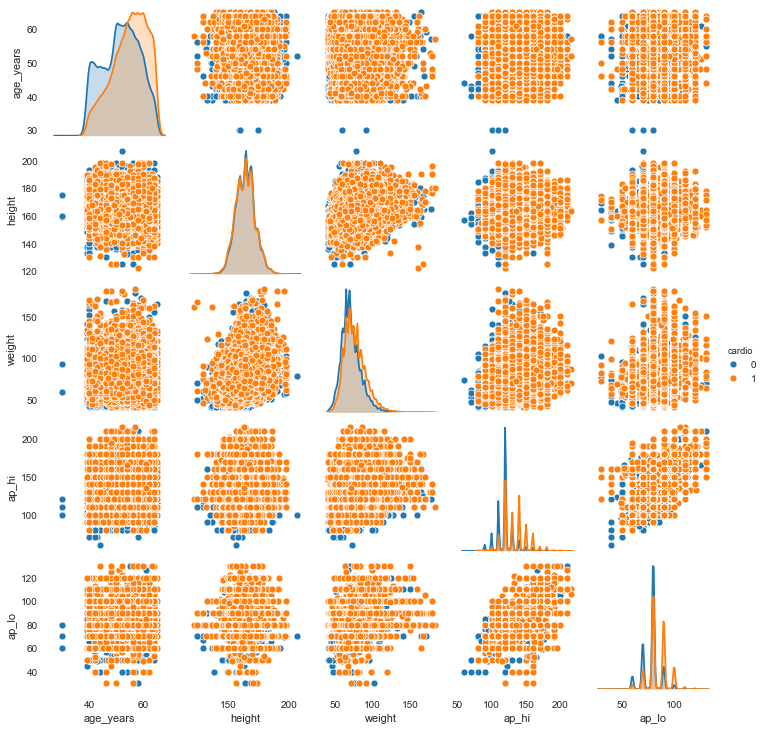

In [4]:
# pairwise plots of cont features
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.pairplot(df_onehot, vars = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo'],  hue='cardio', height=2, diag_kws={'bw':'1.0'})


As there are many observations, its not easy to see many patterns or relationships between features. We can see some evidence of expected correlations like a positive trend between height and weight and between systolic and diastolic blood pressure. There does appear to be some positive correlation between weight and blood pressure. Not much is revealed yet by the color coding of CVD diagnosis, except in the plots of each variable that show the 2 outcomes split, where we can see a bit of separation in age and blood pressure. We'll explore those in more detail later.

A heatmap of correlations is useful for quantifying and visualizing relationships between attributes and we can add in the coded categorical variables to this graphic as well.

Text(0.5, 1.0, 'HeatMap-Correlation Matrix')

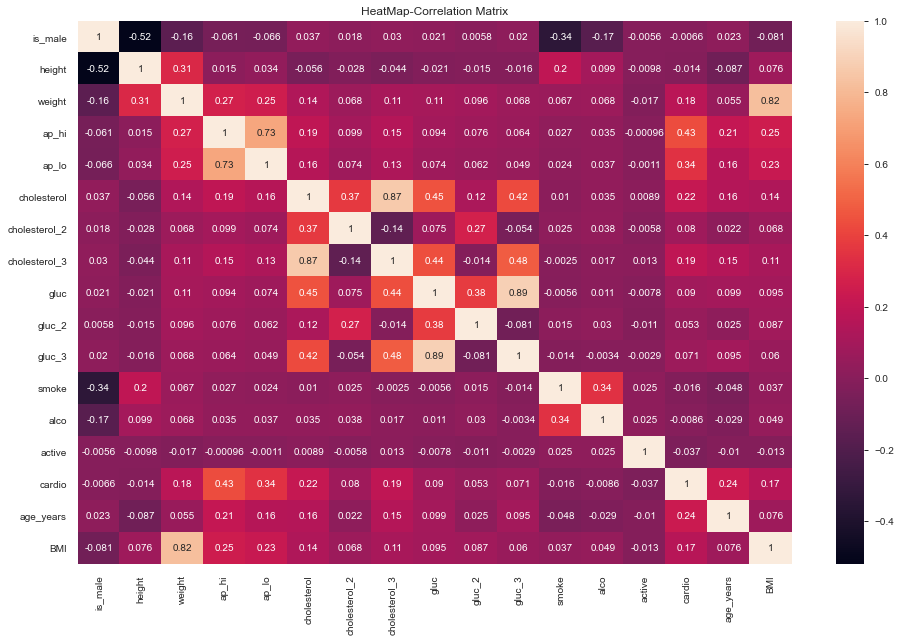

In [5]:
#heatmap - correlation matrix
plt.figure(figsize=(16, 10)) #code reference (5-1)
sns.heatmap(df_onehot.corr(), annot=True)
plt.title('HeatMap-Correlation Matrix')

Firstly, this heatmap demonstrates why it is still important to run the scatterplots. We can visually determine some of the more "obvious" correlations from the scatterplots and then check how they are quantified in the heatmap. Then we have a reference for determining what the other quantified correlations could mean for variables that were difficult to see on the scatterplots. 

We can see the high correlation between systolic and diastolic blood pressures as .73 and height and weight as .31. Using these as a reference, we can identify some other modest correlations like blood pressures and age at .21 and .16 for ap_hi and ap_lo, which we were unable to discern from the scatterplots. While these aren't particularly high correlations, when compared realtively to the correlation of .31 for height/weight, there is some evidence that these could still be useful.

As far as adding categorical variables, we can see that the levels of cholesterol and glucose tend to correlate with each other, as do the behaviors of smoking and drinking. Individuals who are active don't seem to strongly be characterized by any trait in particular as all of its correlations are low.

We also get a preview of blood pressures being the highest correlated variables with cardio, with age and cholesterol following.

Violin plots can give us a closer look at how the **blood concentrations of glucose and cholesterol** compare distributionally.

Text(0.5, 1.0, 'Glucose Vs Cholesterol')

<Figure size 1152x2160 with 0 Axes>

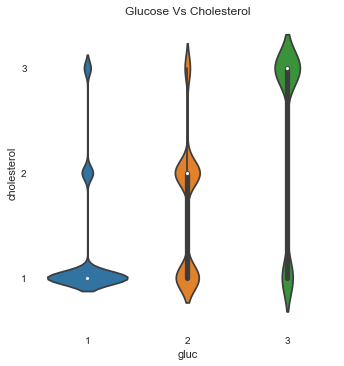

In [6]:
# Relationship between Glucose and Cholesterol
plt.figure(figsize=(16, 30))
sns.catplot(x="gluc", y="cholesterol", kind="violin", data=df_onehot);
plt.yticks([1,2,3])
plt.title('Glucose Vs Cholesterol')

The above violin plots show that at lower level of glucose, the percentage of people with high cholesterol level(3) is low. With the increase of glucose level to 3, the percentage of people having high level of cholesterol (level 3) increases significantly. 

Now We can split glucose and cholesterol by cardio to see how they change depending on CVD.

Text(0.5, 1.0, 'Glucose Vs Cholesterol')

<Figure size 1152x2160 with 0 Axes>

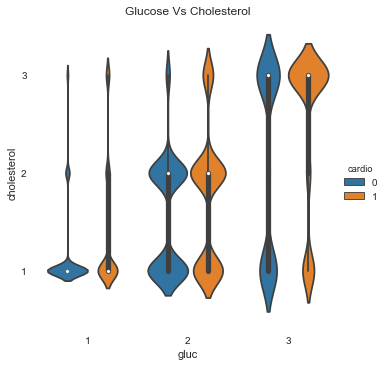

In [7]:
# Relationship between Glucose and Cholesterol with respect to Cardio
plt.figure(figsize=(16, 30))
sns.catplot(x="gluc", y="cholesterol", kind="violin", hue='cardio', data=df_onehot);
plt.yticks([1,2,3])
plt.title('Glucose Vs Cholesterol')

Glucose and Cholesterol concentrations appear to track with each other, but there isn't as much evidence from this plot of large distributional changes of these based on cardio. 

## Modeling and Evaluation 1

For this data, we will be attempting to cluster our data on the basis of target feature cardio that we classified against in lab 2, and apply that cluster into our classifier model as an additional feature that could strengthen our classifier. 

Our goal with the cluster is to uncover a hidden variable or relationship within the dataset that can be used to strengthen our classifier. 

#### *Training/Test Split Method*

We chose a stratified k-fold validation algorithm for the classification task of cardio after adding each clustering algoritham output as a new feature to our random forest classification from *lab-2* to see if clustering output improves our classification accuracy. 

In [8]:
#Create Cross Validation Procedure for Classification task
clustering_state = 1234
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, random_state=clustering_state, shuffle=True)

Agglomerative Clustering Algoritham is not executing with entire dataset which consists of 68523 observations, so selected 50% of observations which comes around 34,000 to identify clusters in the dataset with various clustering algorithams

In [9]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(df_onehot[df_onehot.columns.difference(['cardio'])], df_onehot['cardio'], 
                                                        test_size = 0.5, random_state = clustering_state)

Took only most important features from the top performing Random forest classifier from *lab-2* by viewing the coefficents for the weights of each variable in predicting cardio. 

In [10]:
Ind_features=['weight', 'height', 'ap_hi', 'ap_lo','cholesterol_2', 'cholesterol_3']
Dep_feature=['cardio']
data_final_X=X1_train[Ind_features]
data_final_Y=y1_train

The data is normailzed using StandardScaler.

In [11]:
# Normalize the data
scl = StandardScaler()
scaled_X = scl.fit_transform(data_final_X)

The following functions perform cross validation using cross_validate() for classification estimators and returns accuracy, precision, recall for the classification model.

In [12]:
# Model Metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
import time

def displayModel_metrics(best_model, grid_model, features, target, cv):   
    start = time.time()
    cv_results = cross_validate(best_model, features, target, cv=cv, scoring=['accuracy','precision','recall'], n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_accuracy'])
    print(' ')
    print('Mean Accuracy   : ', cv_results['test_accuracy'].mean())
    print('Mean Precision  : ', cv_results['test_precision'].mean())
    print('Mean Recall     : ', cv_results['test_recall'].mean())
    print('Mean Fit Time   : ', cv_results['fit_time'].mean())
    print('Mean Score Time : ', cv_results['score_time'].mean())
    print('CV Time         : ', elapsed_time)
    return

### Random Forest Classification 

Best estimator classification model parameters from Lab 2 

 - 'bootstrap': True 
 - 'max_depth': 15 
 - 'min_samples_leaf': 4 
 - 'min_samples_split': 10 
 - 'n_estimators': 300 
 - 'random_state': 1234

In [13]:
from sklearn.ensemble import RandomForestClassifier

# define parameters       
bootstrap_RF = [True]
max_depth_RF = [15]
min_samples_leaf_RF = [4]
min_samples_split_RF = [10]
random_state_RF = [1234]
n_estimators_RF =  [300]

# define grid search
param_grid_RF = dict(n_estimators=n_estimators_RF, max_depth=max_depth_RF, random_state=random_state_RF,
                    bootstrap=bootstrap_RF, min_samples_leaf=min_samples_leaf_RF,
                    min_samples_split=min_samples_split_RF)

RF = RandomForestClassifier()

grid_search_RF = GridSearchCV(estimator=RF, param_grid=param_grid_RF, n_jobs=-1, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [14]:
%%time
grid_result_RF = grid_search_RF.fit(scaled_X, data_final_Y)
# summarize results
print("Best: %f using %s" % (grid_result_RF.best_score_, grid_result_RF.best_params_))
means = grid_result_RF.cv_results_['mean_test_score']
stds = grid_result_RF.cv_results_['std_test_score']
params = grid_result_RF.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.9s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.0s finished


Best: 0.725081 using {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300, 'random_state': 1234}
0.725081 (0.005380) with: {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300, 'random_state': 1234}
Wall time: 24 s


In [15]:
# Display model metrics
displayModel_metrics(grid_result_RF.best_estimator_, grid_result_RF, scaled_X, data_final_Y, cv)

Fold Scores:
 
[0.73271083 0.71395213 0.72416813 0.72241681 0.7247519  0.73234092
 0.72124927 0.73000584 0.72650321 0.7227087 ]
 
Mean Accuracy   :  0.7250807731807998
Mean Precision  :  0.7636405934270507
Mean Recall     :  0.6475457560394664
Mean Fit Time   :  9.411948299407959
Mean Score Time :  0.30004985332489015
CV Time         :  16.161776304244995


#### KMeans Clustering

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity

KMeans Clustering with default parameters

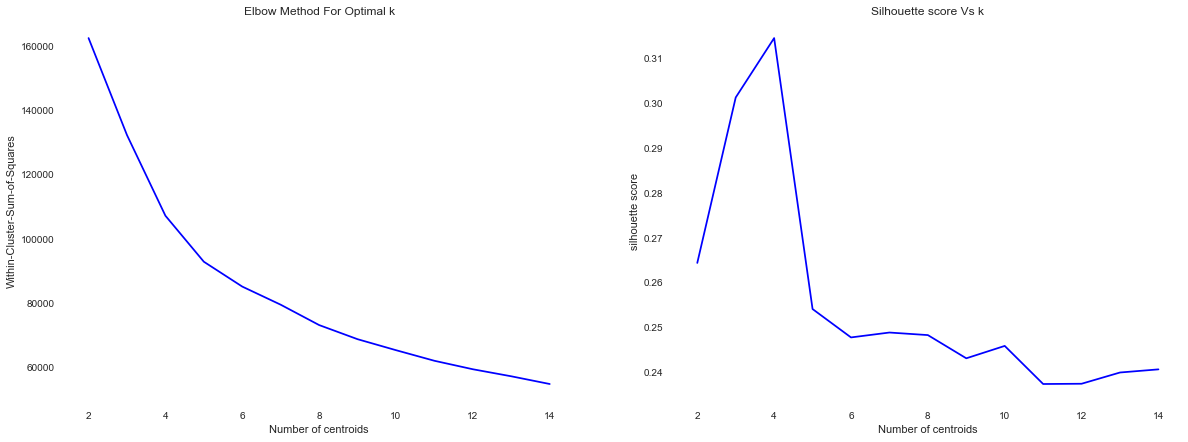

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = []
score = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_X)
    labels = km.predict(scaled_X) 
    wcss.append(km.inertia_)
    sc = silhouette_score(scaled_X, labels)
    score.append(sc)

plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,2,1)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('Within-Cluster-Sum-of-Squares')
plt.title('Elbow Method For Optimal k')

plt.subplot(1,2,2)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

Looking at above elbow method on the dataset with WCSS  and the K-means clustering algorithm, we can see that we are seeing a bit of an elbow around the 5 and 6 point. Looking at silhouette score and the K-means clustering algorithm, we can see that we are seeing a highest silhouette score at k=4 

Let's see how the accuracy of our Randomforest classifier will change by adding cluster details to the datset 

In [17]:
# Run KMeans with default parameters
cls = KMeans(n_clusters=4, random_state=clustering_state)
cls.fit(scaled_X)

newfeature = cls.labels_ 

X_KM_clusters = np.column_stack((scaled_X, pd.get_dummies(newfeature)))

In [18]:
# Display model metrics
displayModel_metrics(grid_result_RF.best_estimator_, grid_result_RF, X_KM_clusters, data_final_Y, cv)

Fold Scores:
 
[0.73212722 0.71920607 0.72358435 0.72124927 0.72621133 0.73204904
 0.72358435 0.72708698 0.72504378 0.72154116]
 
Mean Accuracy   :  0.7251683558895219
Mean Precision  :  0.7677667588629455
Mean Recall     :  0.6413219628989439
Mean Fit Time   :  13.424652671813964
Mean Score Time :  0.34886956214904785
CV Time         :  21.149967432022095


We set up our K-means clustering algorithm with an init of k-means++ with a number of clusters between 2 and 15 to test against our  dataframe. 

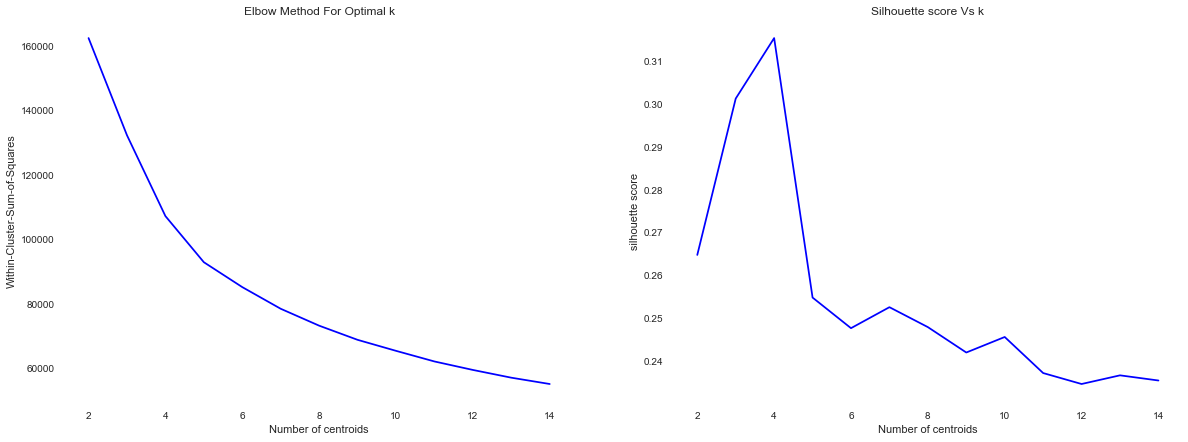

Wall time: 4min 7s


In [19]:
%%time
wcss = []
score = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k, init = 'k-means++')
    km = km.fit(scaled_X)
    labels = km.predict(scaled_X) 
    wcss.append(km.inertia_)
    sc = silhouette_score(scaled_X, labels)
    score.append(sc)

plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,2,1)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('Within-Cluster-Sum-of-Squares')
plt.title('Elbow Method For Optimal k')

plt.subplot(1,2,2)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

Here, we received an average silhouette score with our KMeans cluster of 0.32 both with default parameters and with init of k-means++

In [20]:
# Run KMeans with init = 'k-means++'
cls = KMeans(n_clusters=4, init = 'k-means++', random_state=clustering_state)
cls.fit(scaled_X)

newfeature = cls.labels_ 

X_KM_clusters = np.column_stack((scaled_X, pd.get_dummies(newfeature)))

In [21]:
pred =  cls.labels_
# Get silhouette score
km_sil = silhouette_score(scaled_X, pred, random_state=1234)
print("Average KMeans Silhouette Score:", km_sil)

Average KMeans Silhouette Score: 0.31463377347760346


In [22]:
# Display model metrics
displayModel_metrics(grid_result_RF.best_estimator_, grid_result_RF, X_KM_clusters, data_final_Y, cv)

Fold Scores:
 
[0.73212722 0.71920607 0.72358435 0.72124927 0.72621133 0.73204904
 0.72358435 0.72708698 0.72504378 0.72154116]
 
Mean Accuracy   :  0.7251683558895219
Mean Precision  :  0.7677667588629455
Mean Recall     :  0.6413219628989439
Mean Fit Time   :  15.104201436042786
Mean Score Time :  0.3564368963241577
CV Time         :  23.880781173706055


Kmeans clustering algorithm indentified 6 clusters with respect to with-in cluster sum of squared error and 4 clusters with respect to silhouette score 

#### HDBSCAN (Hierarchical extension of DBSCAN) Clustering

HDBSCAN is a clustering algorithm which extends DBSCAN a density-based clustering method by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters.

There are 2 primary parameters available for tuning in HDBSCAN.

* Minimum Cluster Size: This is the smallest number of observations you wish to consider a cluster
* Minimum Samples: This drives how conservative the clustering is: the higher the value, the more conservative the algorithm will be

http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html.

In [23]:
%%time
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=50).fit(scaled_X)
newfeature = clusterer.labels_ 
X_DBS_clusters = np.column_stack((scaled_X, pd.get_dummies(newfeature)))

Wall time: 10.1 s


In [24]:
print("Number of Clusters Identified with HDBSCAN :", (max(newfeature)-1))

Number of Clusters Identified with HDBSCAN : 4


In [25]:
pred =  clusterer.labels_
# Get silhouette score
dbs_sil = silhouette_score(scaled_X, pred, random_state=1234)
print("Average HDBSCAN Silhouette Score:", dbs_sil)

Average HDBSCAN Silhouette Score: -0.006677021031563402


In [26]:
# Display model metrics
displayModel_metrics(grid_result_RF.best_estimator_, grid_result_RF, X_DBS_clusters, data_final_Y, cv)

Fold Scores:
 
[0.73358623 0.71833041 0.72358435 0.72154116 0.72533567 0.73029772
 0.72124927 0.73117338 0.73000584 0.72562755]
 
Mean Accuracy   :  0.7260731586039982
Mean Precision  :  0.7666479587483088
Mean Recall     :  0.6456668568860807
Mean Fit Time   :  10.4790043592453
Mean Score Time :  0.33976552486419676
CV Time         :  20.68552255630493


In [27]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, min_samples=50).fit(scaled_X)
newfeature = clusterer.labels_ 
X_DBS_clusters = np.column_stack((scaled_X, pd.get_dummies(newfeature)))

In [28]:
print("Number of Clusters Identified with HDBSCAN :", (max(newfeature)-1))

Number of Clusters Identified with HDBSCAN : 3


In [29]:
from sklearn.metrics import silhouette_score
pred =  clusterer.labels_
# Get silhouette score
dbs_sil = silhouette_score(scaled_X, pred, random_state=1234)
print("Average HDBSCAN Silhouette Score:", dbs_sil)

Average HDBSCAN Silhouette Score: 0.11464681329935195


In [30]:
# Display model metrics
displayModel_metrics(grid_result_RF.best_estimator_, grid_result_RF, X_DBS_clusters, data_final_Y, cv)

Fold Scores:
 
[0.73416983 0.71541156 0.72329247 0.72387624 0.72387624 0.73146527
 0.72387624 0.73175715 0.72767075 0.7247519 ]
 
Mean Accuracy   :  0.7260147644533614
Mean Precision  :  0.7655809931501775
Mean Recall     :  0.6471349579174006
Mean Fit Time   :  11.04814121723175
Mean Score Time :  0.3258378267288208
CV Time         :  21.779831409454346


HDBSCAN clustering algorithm indentified 4 clusters and 3 clusters with different values of min_cluster_size parameter. The silhouette score of 0.11 for our DBScan, which was lower than our K-means silhouette score of 0.32 and we are going to be focusing on silhouette score to evaluate the value of our clusters, we will not use a DBscan moving forward with our classifier model.

#### Agglomerative clustering

The agglomerative clustering is the most common type of hierarchical clustering used to group objects in clusters based on their similarity. It's also known as AGNES (Agglomerative Nesting). The algorithm starts by treating each object as a singleton cluster.

Let's indetify how many clusters with respect to "silhouette score" using agglomerative clustering

In [31]:
%%time
scores = scaled_X

linkage_mat = linkage(scores, method="ward")
euc_scores = euclidean_distances(scores)

n_l = 2
n_h = 12

silh_score = -2
# Selecting the best number of clusters based on the silhouette score
for i in range(n_l, n_h):
    local_labels = list(cut_tree(linkage_mat, n_clusters=i).flatten())
    sc = silhouette_score(
        euc_scores,
        metric="precomputed",
        labels=local_labels,
        random_state=clustering_state)
    if silh_score < sc:
        silh_score = sc
        labels = local_labels

n_clusters = len(set(labels))
print(f"Optimal number of clusters: {n_clusters}")
print(f"Best silhouette score: {silh_score}")
# ...

Optimal number of clusters: 3
Best silhouette score: 0.38967930183576854
Wall time: 39min 35s


With respect to "silhouette score", there are 3 clusters in the dataset with silhouette score of 0.3897

In [32]:
%%time

clusterer = cluster.AgglomerativeClustering(n_clusters =3, linkage='ward').fit(scaled_X)
newfeature_AGG = clusterer.labels_ 
X_AGG_clusters = np.column_stack((scaled_X, pd.get_dummies(newfeature_AGG)))

Wall time: 4min 25s


In [33]:
clusters_agg = cluster.AgglomerativeClustering(n_clusters =3, linkage='ward').fit_predict(scaled_X)

In [34]:
# Display model metrics
displayModel_metrics(grid_result_RF.best_estimator_, grid_result_RF, X_AGG_clusters, data_final_Y, cv)

Fold Scores:
 
[0.73329443 0.71745476 0.72095738 0.71920607 0.72387624 0.73263281
 0.72358435 0.72650321 0.72591944 0.72446001]
 
Mean Accuracy   :  0.7247888705654812
Mean Precision  :  0.7639522867564706
Mean Recall     :  0.6462540214865233
Mean Fit Time   :  10.543173003196717
Mean Score Time :  0.3149440765380859
CV Time         :  21.27095127105713


Note: There are memory issues to find number of clusters with linkage of "average" and "complete". 

Agglomerative clustering algorithm indentified 3 clusters with "ward" linkage. The silhouette score of 0.3897 for our Agglomerative clustering, which is higher than kmeans clustering algoritm.

**Gaussian Mixture Model**

Gaussian Mixture Models are probabilistic models and use the soft clustering approach for distributing the points in different clusters

One key parameter we will be looking to optimize for GMM is the covariance type which will control how the covariances are treated between clusters. By default, 'full' is used which allows each cluster it's own general covariance matrix. The other alternatives are 'tied' where all clusters share the same general covariance matrix, 'spherical’' is used which allows each cluster has its own single variance and 'diag' where each cluster has its own diagonal covariance matrix

Now lets see how GMM with different covariance type identifies clusters in our dataset

Best silhouette score 0.3123554620088508


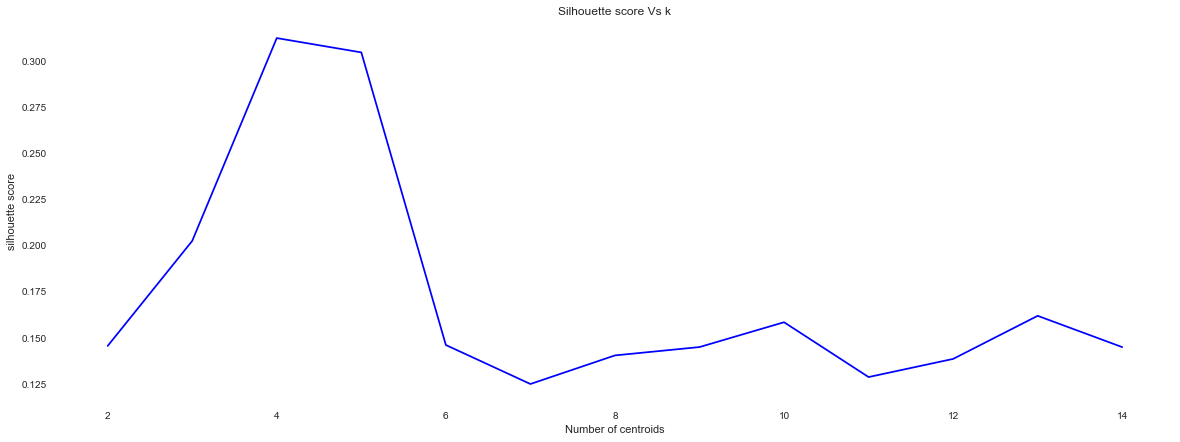

Wall time: 3min 48s


In [35]:
%%time
# GMM using 'spherical' covariance type
from sklearn.mixture import GaussianMixture as GMM
score = []
K = range(2,15)
for k in K:
    gmm_c = GMM(n_components=k, covariance_type='spherical')
    gmm_fit = gmm_c.fit(scaled_X)
    gmm_labels = gmm_fit.predict(scaled_X) 
    sc = silhouette_score(scaled_X, gmm_labels)
    score.append(sc)

print("Best silhouette score", max(score))
plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,1,1)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

Best silhouette score 0.39008087816569287


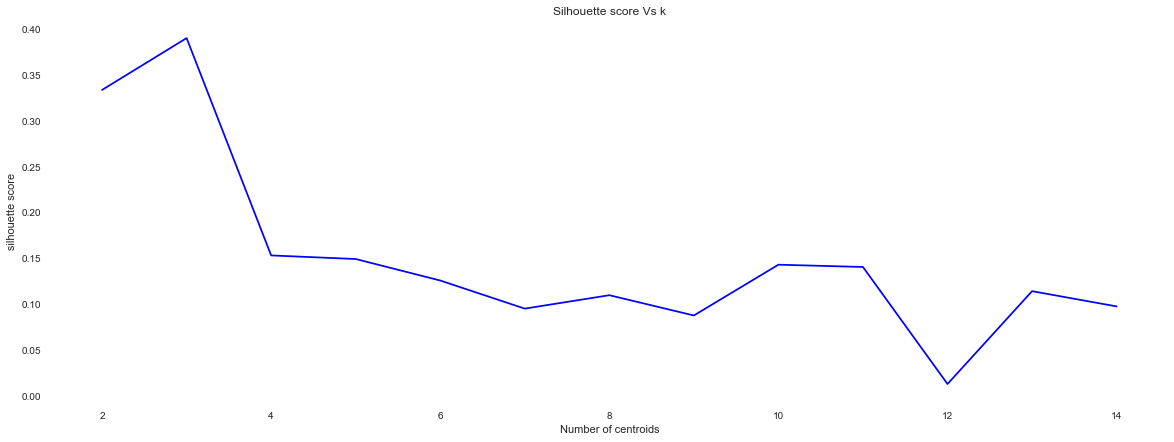

Wall time: 4min 26s


In [36]:
%%time
# GMM using 'full' covariance type
score = []
K = range(2,15)
for k in K:
    gmm_c = GMM(n_components=k, covariance_type='full')
    gmm_fit = gmm_c.fit(scaled_X)
    gmm_labels = gmm_fit.predict(scaled_X) 
    sc = silhouette_score(scaled_X, gmm_labels)
    score.append(sc)

print("Best silhouette score", max(score))
plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,1,1)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

Best silhouette score 0.39008087816569287


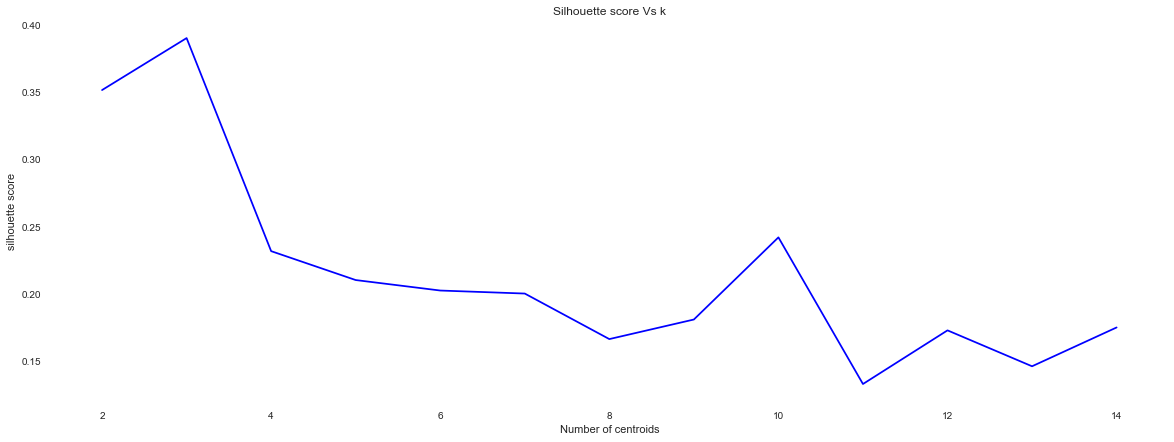

Wall time: 4min 32s


In [37]:
%%time
# GMM using 'tied' covariance type
score = []
K = range(2,15)
for k in K:
    gmm_c = GMM(n_components=k, covariance_type='tied')
    gmm_fit = gmm_c.fit(scaled_X)
    gmm_labels = gmm_fit.predict(scaled_X) 
    sc = silhouette_score(scaled_X, gmm_labels)
    score.append(sc)

print("Best silhouette score", max(score))
plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,1,1)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

Best silhouette score 0.39008087816569287


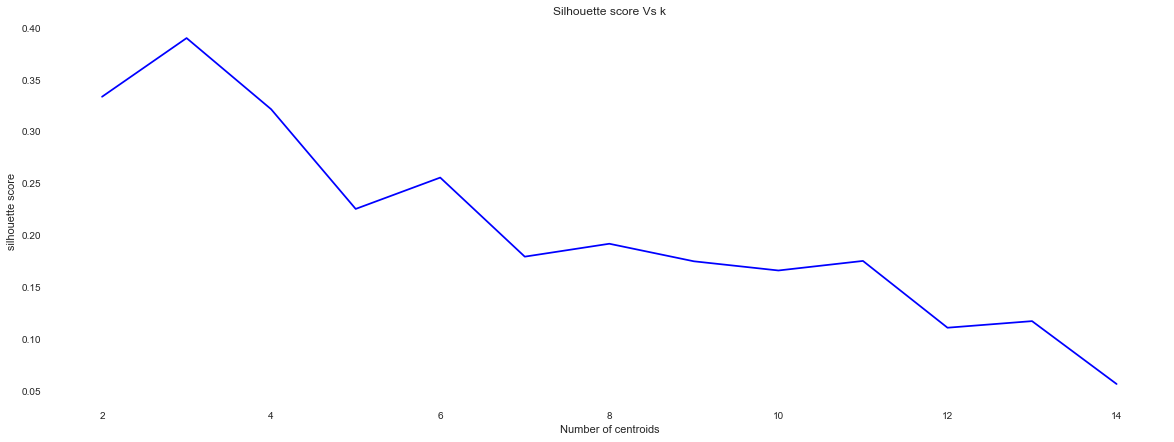

Wall time: 4min 19s


In [38]:
%%time
# GMM using 'diag' covariance type
score = []
K = range(2,15)
for k in K:
    gmm_c = GMM(n_components=k, covariance_type='diag')
    gmm_fit = gmm_c.fit(scaled_X)
    gmm_labels = gmm_fit.predict(scaled_X) 
    sc = silhouette_score(scaled_X, gmm_labels)
    score.append(sc)

print("Best silhouette score", max(score))
plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,1,1)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()


GMM clustering algorithm indentified 3 clusters with best silhouette score of 0.39 using Covariance types 'full', 'tied' and 'diag' where as Covariance type 'spherical' is identifying 4 clusters with silhouette score of 0.312. 

We will also be looking at other parameter init_params which takes 'kmeans’ and 'random'. There could be some initial weights, means and precisions that became apparent in our clustering that we can include in our GMM algorithm so it can correctly start clustering. This is performed by a single round of k-means clustering with a round specified in n_init.

We will test these parameters 3 and 5 init to see if they increase our silhouette score. First, let's begin by testing kmeans initiation rather than one based on random:

Best silhouette score 0.39008087816569287


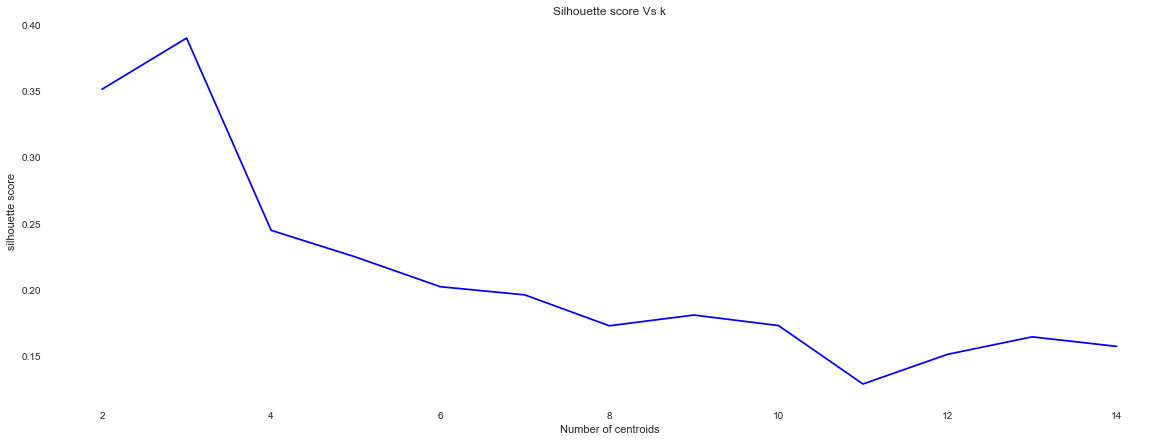

Wall time: 5min 6s


In [39]:
%%time
# GMM using 'tied' covariance type, 'kmeans' init_params and 3 n_init
score = []
K = range(2,15)
for k in K:
    gmm_c = GMM(n_components=k, covariance_type='tied', init_params='kmeans',
               n_init=3)
    gmm_fit = gmm_c.fit(scaled_X)
    gmm_labels = gmm_fit.predict(scaled_X) 
    sc = silhouette_score(scaled_X, gmm_labels)
    score.append(sc)

print("Best silhouette score", max(score))
plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,1,1)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

Best silhouette score 0.39008087816569287


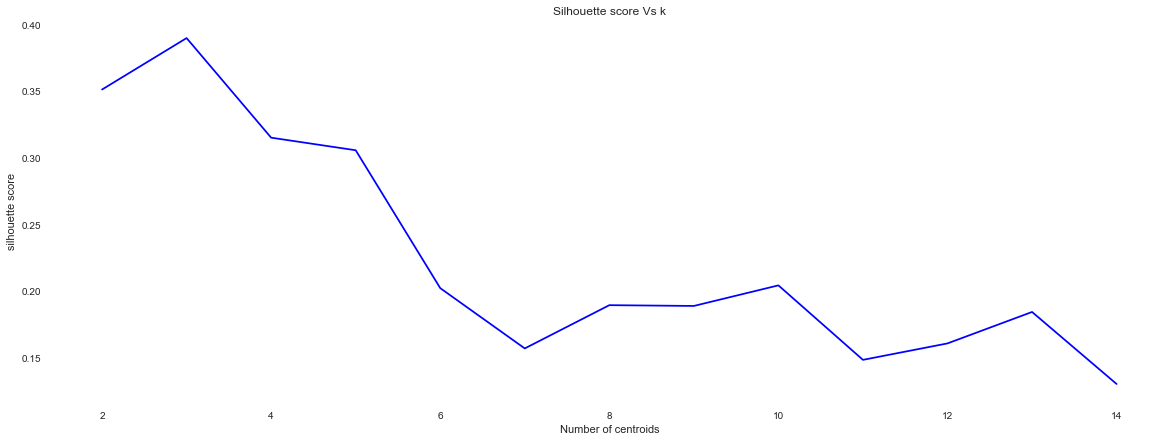

Wall time: 5min 58s


In [40]:
%%time
# GMM using 'tied' covariance type, 'kmeans' init_params and 5 n_init
score = []
K = range(2,15)
for k in K:
    gmm_c = GMM(n_components=k, covariance_type='tied', init_params='kmeans',
               n_init=5)
    gmm_fit = gmm_c.fit(scaled_X)
    gmm_labels = gmm_fit.predict(scaled_X) 
    sc = silhouette_score(scaled_X, gmm_labels)
    score.append(sc)

print("Best silhouette score", max(score))
plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,1,1)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

Best silhouette score 0.1763808125421565


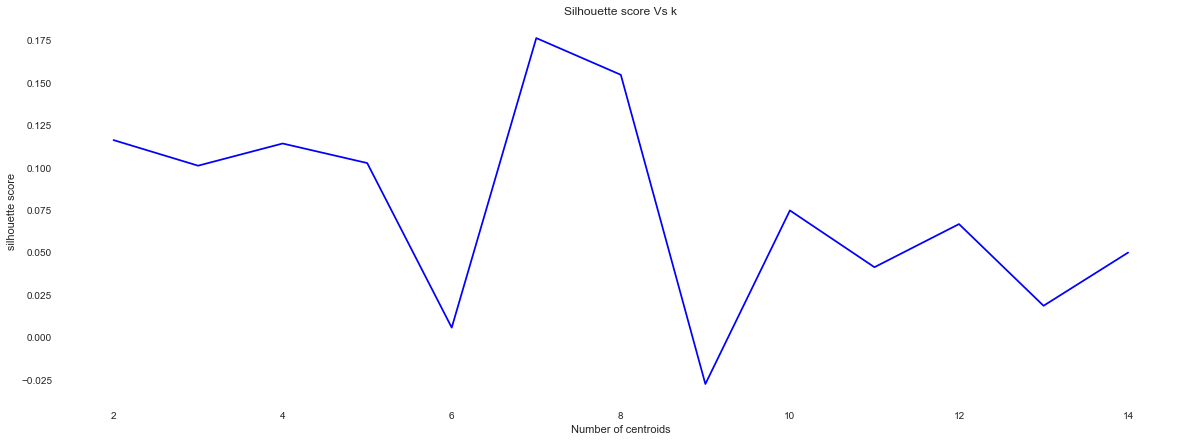

Wall time: 4min 14s


In [41]:
%%time
# GMM using 'tied' covariance type, 'random' init_params 
score = []
K = range(2,15)
for k in K:
    gmm_c = GMM(n_components=k, covariance_type='tied', init_params='random')
    gmm_fit = gmm_c.fit(scaled_X)
    gmm_labels = gmm_fit.predict(scaled_X) 
    sc = silhouette_score(scaled_X, gmm_labels)
    score.append(sc)

print("Best silhouette score", max(score))
plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,1,1)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

With 'random' initiation the processing time decreased significantly but this model identified 7 clusters in our dataset with significant drop in silhouette score 0.176. 'random' initiation took less processing time which is likely because the k-means initiation requires substantial processing that can be circumvented by running a random init instead. 

There is no change in number of clusters in our dataset and also silhouette score with additional parameters init_params of kmeans and n_init of 3 and 5. we will move forward with the 'tied' covariance type to validate accuracy of Random forest classifier.

In [42]:
%%time

gmm = GMM(n_components=3, covariance_type='tied') 
gmm_labels = gmm.fit_predict(scaled_X) 
X_gmm_clusters = np.column_stack((scaled_X, pd.get_dummies(gmm_labels)))

Wall time: 328 ms


In [43]:
displayModel_metrics(grid_result_RF.best_estimator_, grid_result_RF, X_gmm_clusters, data_final_Y, cv)

Fold Scores:
 
[0.73037642 0.71716287 0.72387624 0.71833041 0.7227087  0.73088149
 0.72329247 0.72562755 0.72446001 0.72329247]
 
Mean Accuracy   :  0.7240008646695116
Mean Precision  :  0.7625054510230548
Mean Recall     :  0.6462539525664459
Mean Fit Time   :  19.28986587524414
Mean Score Time :  0.5212059020996094
CV Time         :  33.77307176589966


## Modeling and Evaluation 2

**Evaluate and Compare**

We are now going to validate our clustering so that it can be compared to other potential clustering methods. As discussed above we are going to use silhouette metric, which is a measure of the closeness of a point to the average at the center of it's cluster combined with the smallest distance between the same point and the next closest cluster. This will be useful to quantify how useful our clustering is. The optimal at 1.0, so higher values are desired. 

In addition to the above metrics to identify best clustering algorithm, we will also be looking at the respective time it took to run our clustering model. Since we are working with a subset of data from a bigger dataset, we will need to factor in time efficiency when choosing our best model.

Finally, we will take the clustering output as a new feature to our random forest classification and see which clustering algoritm improves the accuracy. 

The table below shows a summary of the performance of 4 tested clustering models based on the metrics outlined in the "Modeling and Evaluation" section:

|Model   | Silhouette score  | Run time | Number of Clusters|
|:---------|:---------------| :---------------| :---------------|
| KMeans | 0.3146| 4m 7s | 4 |
| HDBSCAN | 0.1146 | 10.1s | 3 |
| Agglomerative clustering | 0.3896 | 39m 35s | 3 |
| GMM | 0.39 | 4m 14s | 3 |

With respect the Silhouette score, GMM clustering algoritm is best algorithm in indentifying the clusters in our cardio dataset. GMM clustering algorithm indentified 3 clusters even time complexity for GMM clustering algorithm is less with other  algoritms

The table below shows a summary of the performance of Random Forest classifier wiht clustering output as a new feature

|Model   |Accuracy(%)   |Precision(%)   |Recall(%)  |
|:---------|:---------------|:---------------|:---------------|
| KMeans |   72.52 | 76.78 | 64.13|
| HDBSCAN  | 72.60 | 76.56 | 64.71 | 
| Agglomerative clustering |  72.48 | 76.40 | 64.63 |
| Without Clusters |  72.51 | 76.40 | 64.75 |

There is little increase in Accuracy, Precision and Recall with all three tested clustering aligotims, but the change is not significant.

## Modeling and Evaluation 3

**Visualize Results**

We will use a technique called t-SNE (t-distributed Stochastic Neighbor Embedding) to generate a 2 dimensional representation of our dataset, in order to have a more intuitive understanding of how the clustering looks.

First let's look at an un-clustered version of this 2D projection.

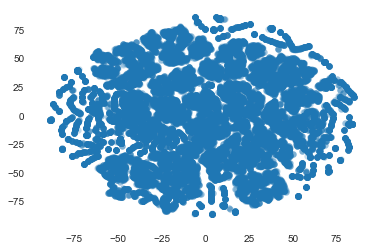

Wall time: 5min 45s


In [44]:
%%time
from sklearn.manifold import TSNE
import sklearn.cluster as cluster
newdims = (6, 4)
plt.subplots(1, 1, figsize=newdims)
plt.subplot(1, 1, 1)
plot_kwds = {'alpha' : 0.25, 's' : 40, 'linewidths':0}
projection = TSNE().fit_transform(scaled_X)
plt.scatter(*projection.T, **plot_kwds)
plt.show()

Now look at clustered version of this 2D projection with various clustering techniques

In [45]:
%%time
import seaborn as sns

# This function will run a given clustering algorithm and plot the clusters on the same 2D  TSNE projection as above
def plot_clusters(data, algorithm, args, kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('muted', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (.5, .5, .5) for x in labels]
    plt.scatter(*projection.T, s=50, linewidth=0, c=colors, alpha=0.25)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=14)

Wall time: 0 ns


Wall time: 6min 17s


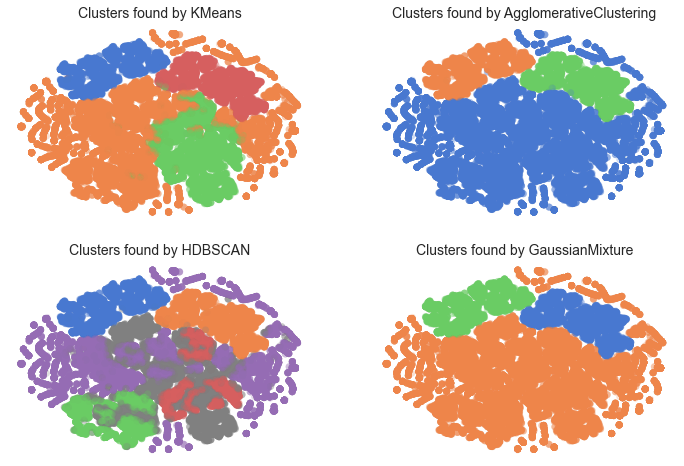

In [46]:
%%time
# plot the clusters
newdims = (12, 8)
plt.subplots(2, 2, figsize=newdims)
plt.subplot(2, 2, 1)
plot_clusters(scaled_X, cluster.KMeans, (), {'n_clusters':4})

plt.subplot(2,2,2)
plot_clusters(scaled_X, cluster.AgglomerativeClustering, (), {'n_clusters':3})

plt.subplot(2, 2, 3)
plot_clusters(scaled_X, hdbscan.HDBSCAN, (), {'min_cluster_size':1000, 'min_samples':50})

plt.subplot(2, 2, 4)
plot_clusters(scaled_X, GMM, (), {'n_components':3, 'covariance_type':'tied'})

Lets look at how the observations are distributed among the identified clusters

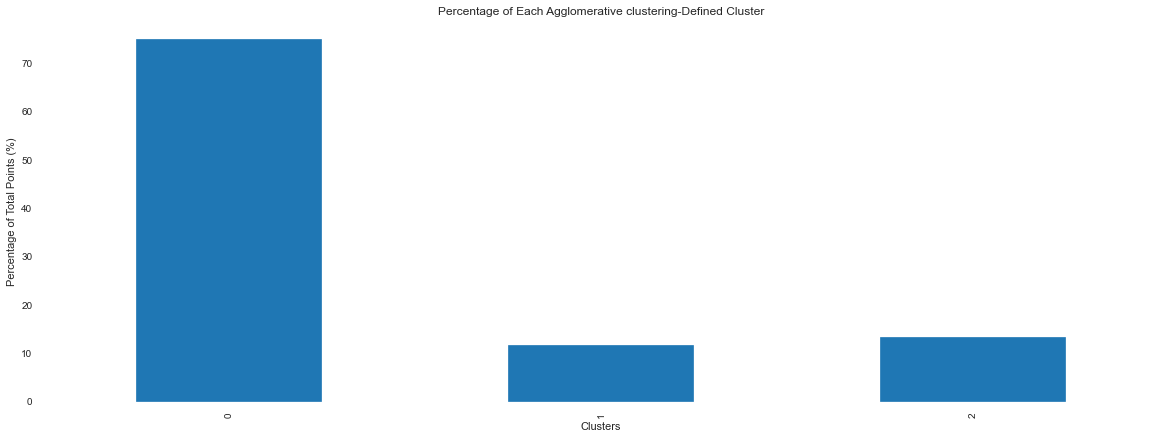

In [47]:
# Create a new dataframe with the clusters defined as a new variable
df_agg = pd.DataFrame(scaled_X.copy(), columns=Ind_features)
df_agg['Clusters'] = clusters_agg
df_agg['cardio'] = y1_train.values

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts = df_agg.groupby('Clusters').count()['cardio'] / len(scaled_X) * 100

# Plot the distribution
ax = cluster_pcts.plot(kind='bar', title="Percentage of Each Agglomerative clustering-Defined Cluster")
_ = ax.set_ylabel("Percentage of Total Points (%)")

Creating a plot that shows the percentage of each Agglomerative clustering algorithm defined clusters using our Silhouette score, we can see that cluster 0 is taking up the majority of the percentage of observations as shown in the 2D projection above.

## Modeling and Evaluation 4

**Summarize the Ramifications**

At best, clustering is achieving a minimal improvement of accuracy over the random forest with this data set. We have a result of a mere .1% improvement using HDBSCAN that exists within a data group variance of 1%, overall. The Agglomerative clustering was slightly worse than our non cluster baseline. It is possible that the differences are statistically significant but we are using an abundance of data and must consider the problem of over fitting our data.

There are no clear data perturbations for clustering to lever greater accuracy above the random forest method. This suggests that the greater computational load is not justifiable. To support this conclusion, we will consider the Silhouette scores. Our highest accuracy was with HDBSCAN. The accompanying silhouette score was 0.1146. This indicates cluster overlap. Our best silhouette score was with Agglomerative clustering with 0.3896. This method also had a lower accuracy than our baseline. This comes at a much increased processing time.

The measures of our model accuracy, precision and recall do not have a substantial variance between clustering types. The poor performance of the clustering suggests that multiple clusters are the result of noise. Agglomerative/GMM clustering, our method with the best silhouette score, pulled most data into a single large cluster with two lesser groups. The sub grouping may have significance but the emphasis of the main group highlights the lack of utility for clustering this data.

Our data evenly splits between samples of patients with cardio vascular disease (CVD) and without. If we use a completely random model, we should expect an accuracy of 50%. That our model is producing an accuracy of 70% is indicative of some legitimate utility. We are measuring the various attributes as correlating to CVD. As such, we cannot infer causal relationships. Factors such as high blood pressure are already counted as being contributing to risk. Thus, we can consider our model as a predictor of risk.

To refine our model, or find greater leverage in a clustering algorithm, we would require additional contributing factors.




## Deployment

Our model is focused on identifying cardio vascular disease, CVD. As a serious medical problem that can affect the entire population, even minor improvements to identification or treatment can save a significant number of lives. This must be balanced against the dangers of over diagnosis or treatment causing more harm than good.

Ideally, this model would be used as an early filter for more involved tests to identify cardiovascular disease. In that usage, a high false positive rate would be justified if it meant a reliably low false negative rate. We do not have this. To achieve that, we would require additional information. For example, we have no indicators for patient's personal or family history.

There are known, or believed, risk factors to CVD that our model does not include. We do not have family history or ethnic demographics. We have no data on medications.  https://www.nhs.uk/conditions/cardiovascular-disease/

Alternatively, we can use this model to indicate relative risks. It is clear, from prior testing, that high blood pressure is a significant risk factor. This sort of information can be used to inform a patient about risk mitigation. 

A medical practitioner would likewise find the modeling useful as a risk percentage calculator. This requires medical expertise to do properly. Varying risk percentage thresholds can be used to recommend more involved tests. For our purposes, these tests could be the source of better data to refine our results into a more accurate risk determination.

Since this model is more a tool of reference than a summary of developing knowledge, it does not need to be updated frequently. This is good, as doing so can be very computationally intensive for the accuracy and reliability we want. An annual model update would be expected as a method to measure population changes over time, as well as the impact of developing interventions. 


## Exceptional Work

The **similarity matrix** is a simple representation of pair combinations, intended to give you a quick insight into the cards your participants paired together in the same group the most often.

The similarity measure is the measure of how much alike two data objects are. A similarity measure is a distance with dimensions representing features of the objects. If the distance is small, the features are having a high degree of similarity. Whereas a large distance will be a low degree of similarity.

***Similarity Matrix with euclidean distance***

Euclidean distance is the most common use of distance measure. It is the square root of the sum of squared differences between corresponding elements of the two vectors

In [38]:
%%time
import math

def euclidean_similarity(x1, x2):
    suma = 0
    for i in range(len(x1)):
        suma += pow(x1[i] - x2[i], 2)
    return math.sqrt(suma)
 
def buildSimilarityMatrix(scaled_X):
    numOfSamples = scaled_X.shape[0]
    matrix = np.zeros(shape=(numOfSamples, numOfSamples))
    for i in range(len(matrix)):
        x_i = scaled_X[i, :]
        for j in range(len(matrix)):
            x_j = scaled_X[j, :]
            dist = euclidean_similarity(x_i, x_j)
            matrix[i,j] = 1/(1+dist)
    return matrix
 
ED_mat = buildSimilarityMatrix(scaled_X)

print("Similarity Matrix using Euclidean Distance:", ED_mat)

Similarity Matrix using Euclidean Distance: [[1.         0.21208847 0.19174104 ... 0.19124171 0.17036501 0.22924221]
 [0.21208847 1.         0.39728154 ... 0.36069672 0.28573353 0.21418337]
 [0.19174104 0.39728154 1.         ... 0.71929121 0.47517791 0.22715827]
 ...
 [0.19124171 0.36069672 0.71929121 ... 1.         0.48190477 0.22098267]
 [0.17036501 0.28573353 0.47517791 ... 0.48190477 1.         0.2136898 ]
 [0.22924221 0.21418337 0.22715827 ... 0.22098267 0.2136898  1.        ]]
Wall time: 1h 23min 48s


In [39]:
# Heapmap of similarity matrix
# sns.clustermap(ED_mat)

***Similarity Matrix with cosine distance***

Cosine similarity is a metric used to determine how similar two entities are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.

In [40]:
from IPython.display import Image
Image(url="https://i.stack.imgur.com/uheR3.png", width=600)

In [41]:
%%time

def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)

def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

def buildSimilarityMatrix(scaled_X):
    numOfSamples = scaled_X.shape[0]
    matrix = np.zeros(shape=(numOfSamples, numOfSamples))
    for i in range(len(matrix)):
        x_i = scaled_X[i, :]
        for j in range(len(matrix)):
            x_j = scaled_X[j, :]
            matrix[i,j] = cosine_similarity(x_i, x_j)
    return matrix
 
CD_mat = buildSimilarityMatrix(scaled_X)

print("Similarity Matrix using Cosine Distance:", CD_mat)

Similarity Matrix using Cosine Distance: [[ 1.     0.148 -0.71  ... -0.63  -0.781  0.506]
 [ 0.148  1.     0.236 ... -0.053 -0.41  -0.199]
 [-0.71   0.236  1.    ...  0.893  0.682 -0.332]
 ...
 [-0.63  -0.053  0.893 ...  1.     0.694 -0.429]
 [-0.781 -0.41   0.682 ...  0.694  0.999 -0.218]
 [ 0.506 -0.199 -0.332 ... -0.429 -0.218  1.   ]]
Wall time: 6h 5min 25s


In [42]:
# Heapmap of similarity matrix
# sns.clustermap(CD_mat)

***Similarity Matrix with Jacard similarity coefficient***

The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets 

In [7]:
%%time

def jaccard_similarity(x,y): 
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

def buildSimilarityMatrix(scaled_X):
    numOfSamples = scaled_X.shape[0]
    matrix = np.zeros(shape=(numOfSamples, numOfSamples))
    for i in range(len(matrix)):
        x_i = scaled_X[i, :]
        for j in range(len(matrix)):
            x_j = scaled_X[j, :]
            matrix[i,j] = jaccard_similarity(x_i, x_j)
    return matrix
 
JD_mat = buildSimilarityMatrix(scaled_X)

print("Similarity Matrix using Jacard Distance:", JD_mat)

Similarity Matrix using Jacard Distance: [[1.         0.09090909 0.09090909 ... 0.09090909 0.2        0.2       ]
 [0.09090909 1.         0.33333333 ... 0.2        0.2        0.09090909]
 [0.09090909 0.33333333 1.         ... 0.5        0.33333333 0.2       ]
 ...
 [0.09090909 0.2        0.5        ... 1.         0.33333333 0.2       ]
 [0.2        0.2        0.33333333 ... 0.33333333 1.         0.09090909]
 [0.2        0.09090909 0.2        ... 0.2        0.09090909 1.        ]]
Wall time: 2h 58min 33s


In [44]:
# Heapmap of similarity matrix
# sns.clustermap(JD_mat)

#### References

 - https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
 
 
 - https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
 
 
 - #https://stackoverflow.com/questions/36490241/sklearn-agglomerative-clustering-dynamically-updating-the-number-of-clusters
 
 
 - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans